## Get Dataframes from Database (takes a while to run)

In [ ]:
!pip install -q mysqlclient
!pip install -q -U sql_magic
from sqlalchemy import create_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.0 MB/s eta 0:00:00


In [ ]:
# Connect to the MySQL, but without selecting a database
conn_string = 'mysql://{user}:{password}@{host}:{port}/{db}?charset={encoding}'.format(
    user='Team_A',
    password='NkC121jpeTE=',
    host = 'jsedocc7.scrc.nyu.edu',
    port     = 3306,
    encoding = 'utf8',
    db = 'Team_A'
)
engine = create_engine(conn_string)

In [ ]:
import pandas as pd
playerSeasonStats = pd.read_sql("SELECT * FROM playerSeasonStats", con=engine)
teamSeasonData = pd.read_sql("SELECT * FROM teamSeasonData", con=engine)
teamSchedule = pd.read_sql("SELECT * FROM teamSchedule", con=engine)
all_players_gamelogs = pd.read_sql("SELECT * FROM all_players_gamelogs", con=engine)

## Graph Player Performance for season

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

def getPlayerStats(playerName):
    playerStats = all_players_gamelogs[(all_players_gamelogs['PLAYER_NAME'] == playerName) & (all_players_gamelogs['MIN'] > 0)]
    return playerStats

def graphPlayerScatterPlot(playerName, stat):
    """
    Graphs a scatter plot of a player's performance for a specific stat
    """
    playerStats = getPlayerStats(playerName)
    if playerStats.empty:
      print(f"No data found for player: {playerName}")
      return

    plt.figure(figsize=(10, 6))
    playerStats['GAME_DATE_NUM'] = (playerStats['GAME_DATE'] - playerStats['GAME_DATE'].min()).dt.days

# NEW - Wins/losses color
    plt.scatter(
        playerStats['GAME_DATE_NUM'],
        playerStats[stat],
        c=playerStats['WL'].map({'W': 'green', 'L': 'red'}),
        zorder=3,
        label='Game Result'
    )

    sns.regplot(
        x='GAME_DATE_NUM',
        y=stat,
        data=playerStats,
        line_kws={'color': 'blue', 'lw': 2},
        ci=None,
        label="Line of Best Fit"
    )
    plt.title(f"{playerName}'s {stat} This Season")
    plt.xlabel('Game Date')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(stat)
    plt.tight_layout()
    plt.show()
    return

def graphPlayerDensityPlot(playerName, stat):
    """
    Graphs a density plot of a player's performance for a specific stat
    """
    playerStats = getPlayerStats(playerName)
    if playerStats.empty:
        print(f"No data found for player: {playerName}")
        return

    scatterplot = playerStats.plot(kind='scatter', x='GAME_DATE', y=stat, figsize=(10, 6))
# NEW - Wins/losses color
    plt.scatter(
        playerStats['GAME_DATE'],
        playerStats[stat],
        c=playerStats['WL'].map({'W': 'green', 'L': 'red'}),
        zorder=3
    )

    sns.kdeplot(x=playerStats['GAME_DATE'], y=playerStats[stat], cmap=plt.cm.Blues, ax = scatterplot)
    plt.title(f"Density Plot of {playerName}'s {stat}")
    plt.xlabel('Game Date')
    plt.ylabel(stat)
    plt.tight_layout()
    plt.show()

# def graphTimeSeriesPlot(playerName, stat):
#     """
#     Graphs a time series plot of a player's performance for a specific stat
#     """
#     plt.rcParams['figure.figsize'] = (20, 5)
#     fig, ax = plt.subplots()
#     playerStats = getPlayerStats(playerName)
#     if playerStats.empty:
#         print(f"No data found for player: {playerName}")
#         return
#     ax.plot(playerStats['GAME_DATE'], playerStats[stat]);


#     ax.set_xlabel("Time");
#     ax.set_ylabel(stat);
#     ax.set_title(f"{playerName}'s {stat} Performance Over Time")

#     # Add rolling average time-series (every 4 games)
#     ax.plot(playerStats['GAME_DATE'], playerStats[stat].rolling(window=4).median(), color='red', label='Rolling Median');
#     ax.legend()

def graphTimeSeriesPlot(playerName, stat):
    """
    Graphs a time series plot of a player's performance for a specific stat
    """
    playerStats = getPlayerStats(playerName)
    if playerStats.empty:
        print(f"No data found for player: {playerName}")
        return

    # Compute rolling median
    playerStats['RollingMedian'] = playerStats[stat].rolling(window=4).median()

    # Create interactive plot
    fig = px.line(playerStats, x='GAME_DATE', y=[stat, 'RollingMedian'],
                  labels={'value': stat, 'GAME_DATE': 'Time', 'variable': 'Legend'},
                  title=f"{playerName}'s {stat} Performance Over Time")

    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(showlegend=True)
    fig.show()

# def graphTimeSeriesPlotAllStats(playerName):
#     """
#     Graphs a time series plot of a player's performance for PTS, REB, and AST
#     """
#     plt.rcParams['figure.figsize'] = (20, 5)
#     fig, ax = plt.subplots()
#     playerStats = getPlayerStats(playerName)
#     if playerStats.empty:
#         print(f"No data found for player: {playerName}")
#         return

#     ax.plot(playerStats['GAME_DATE'], playerStats["PTS"], color="red", label="Points");
#     ax.plot(playerStats['GAME_DATE'], playerStats["REB"], color="green", label="Rebounds");
#     ax.plot(playerStats['GAME_DATE'], playerStats["AST"], color="blue", label="Assists");


#     ax.set_xlabel("Time")
#     ax.set_ylabel("Stats")
#     ax.set_title(f"{playerName}'s Performance Over Time")
#     ax.legend()

import plotly.express as px
import pandas as pd

def graphTimeSeriesPlotAllStats(playerName):
    """
    Graphs a time series plot of a player's performance for PTS, REB, and AST
    """
    playerStats = getPlayerStats(playerName)
    if playerStats.empty:
        print(f"No data found for player: {playerName}")
        return

    # Melt the dataframe to long format for Plotly Express
    stats_long = playerStats.melt(
        id_vars='GAME_DATE',
        value_vars=['PTS', 'REB', 'AST'],
        var_name='Stat',
        value_name='Value'
    )

    # Create interactive plot
    fig = px.line(
        stats_long,
        x='GAME_DATE',
        y='Value',
        color='Stat',
        labels={'GAME_DATE': 'Time', 'Value': 'Stats'},
        title=f"{playerName}'s Performance Over Time"
    )

    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(showlegend=True)
    fig.show()

<ipython-input-4-ed1ca4e72cd6>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playerStats['GAME_DATE_NUM'] = (playerStats['GAME_DATE'] - playerStats['GAME_DATE'].min()).dt.days


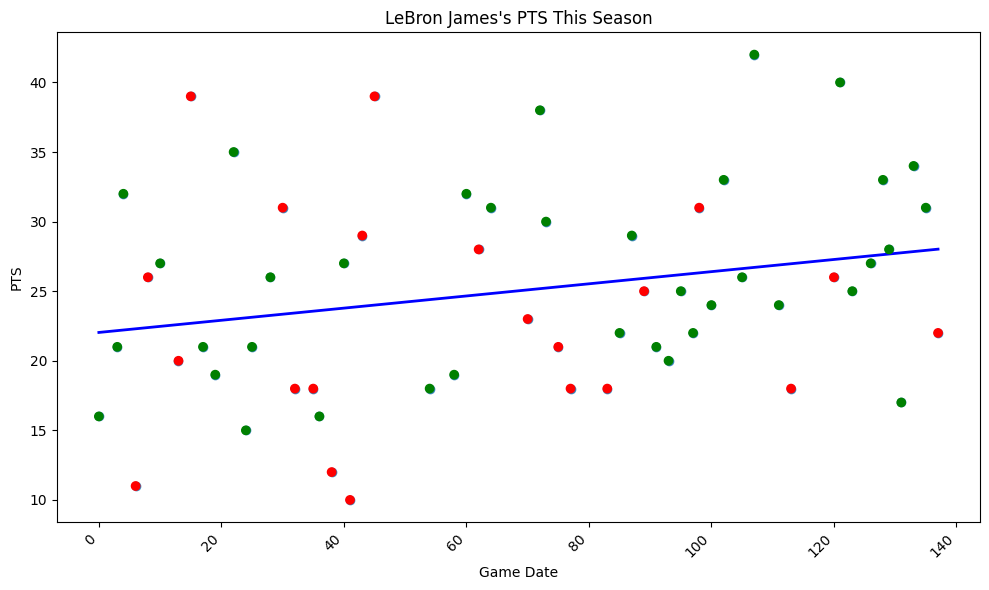

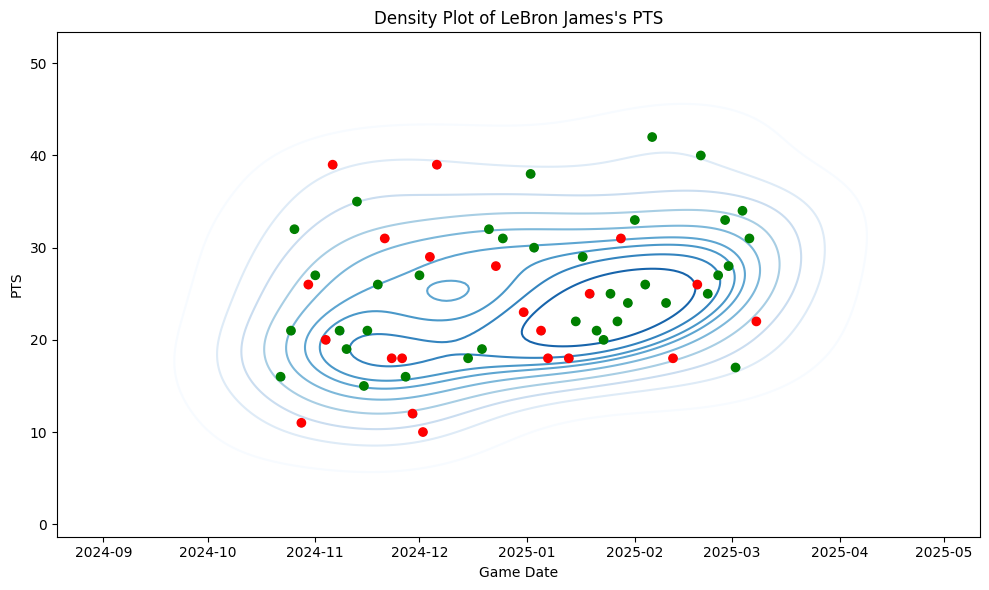

<ipython-input-4-ed1ca4e72cd6>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playerStats['RollingMedian'] = playerStats[stat].rolling(window=4).median()


In [ ]:
player_name = 'LeBron James'
stat = 'PTS'
graphPlayerScatterPlot(player_name, stat)
graphPlayerDensityPlot(player_name, stat)
graphTimeSeriesPlot(player_name, stat)
graphTimeSeriesPlotAllStats(player_name)

In [ ]:
all_players_gamelogs.dtypes

,0
GAME_DATE,datetime64[ns]
WL,object
MIN,int64
FGM,int64
FGA,int64
FG_PCT,float64
FG3M,int64
FG3A,int64
FG3_PCT,float64
FTM,int64


# Players ranked against each other

In [ ]:
def rank_players_by_stat(stat, ascending=False):
    """
    Ranks players by a given stat
    """
    filtered_df = all_players_gamelogs[all_players_gamelogs['MIN'] > 0].copy()
    player_avg = filtered_df.groupby('PLAYER_NAME')[stat].mean().reset_index()
    player_avg = player_avg.sort_values(by=stat, ascending=ascending).reset_index(drop=True)
    player_avg['Rank'] = player_avg.index + 1
    return player_avg


def composite_ranking(stats=['PTS', 'REB', 'AST']):
    """
    Creates a composite ranking for players based on multiple stats.
    """
    filtered_df = all_players_gamelogs[all_players_gamelogs['MIN'] > 0].copy()
    player_stats = filtered_df.groupby('PLAYER_NAME')[stats].mean().reset_index()

    for stat in stats:
         player_stats[stat + '_z'] = (player_stats[stat] - player_stats[stat].mean()) / player_stats[stat].std()
    player_stats['Composite'] = player_stats[[stat + '_z' for stat in stats]].sum(axis=1)

    player_stats = player_stats.sort_values(by='Composite', ascending=False).reset_index(drop=True)
    player_stats['Rank'] = player_stats.index + 1

    columns_to_show = ['PLAYER_NAME', 'Composite', 'Rank'] + stats
    return player_stats[columns_to_show]


points_ranking = rank_players_by_stat('PTS', ascending=False)
print(points_ranking.head(10))

composite_rank = composite_ranking(stats=['PTS', 'REB', 'AST'])
print("")
print("Composite Ranking (PTS, REB, AST):")
print(composite_rank.head(10))


               PLAYER_NAME        PTS  Rank
0  Shai Gilgeous-Alexander  32.969697     1
1    Giannis Antetokounmpo  30.232143     2
2             Nikola Jokić  29.129032     3
3          Anthony Edwards  27.597015     4
4              Luka Dončić  27.351351     5
5             Jayson Tatum  27.142857     6
6             Kevin Durant  26.375000     7
7            Jalen Brunson  26.327869     8
8             Tyrese Maxey  26.326923     9
9            Anthony Davis  25.744186    10

Composite Ranking (PTS, REB, AST):
             PLAYER_NAME  Composite  Rank        PTS        REB        AST
0           Nikola Jokić  11.257660     1  29.129032  12.838710  10.274194
1  Giannis Antetokounmpo   8.798432     2  30.232143  12.035714   6.035714
2       Domantas Sabonis   7.991715     3  19.172414  13.862069   6.224138
3            Luka Dončić   7.965563     4  27.351351   8.513514   7.918919
4           LeBron James   7.825028     5  25.000000   8.206897   8.534483
5        Cade Cunningham   7.4

<ipython-input-8-3d9e2977af60>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




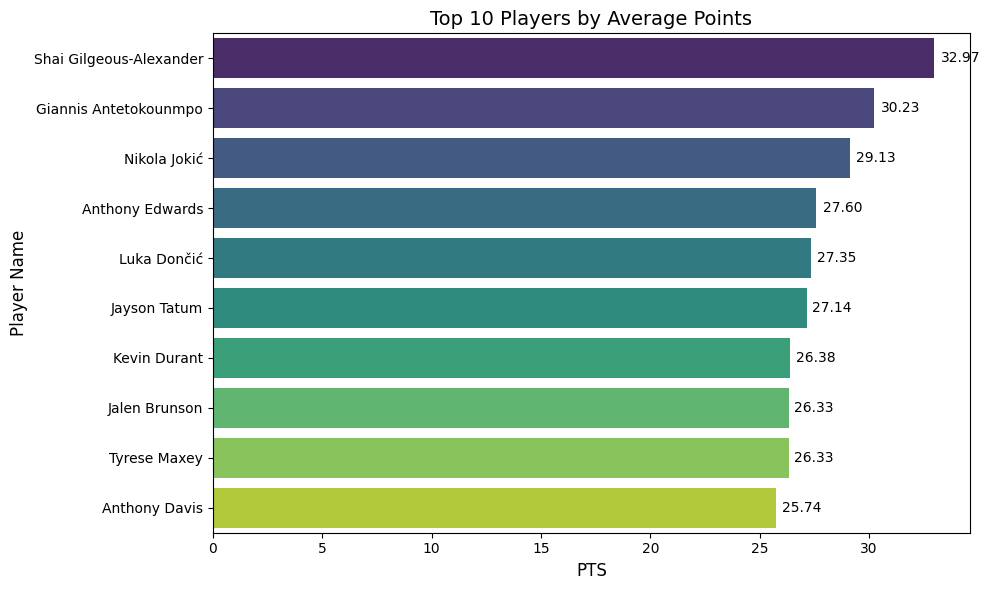

<ipython-input-8-3d9e2977af60>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




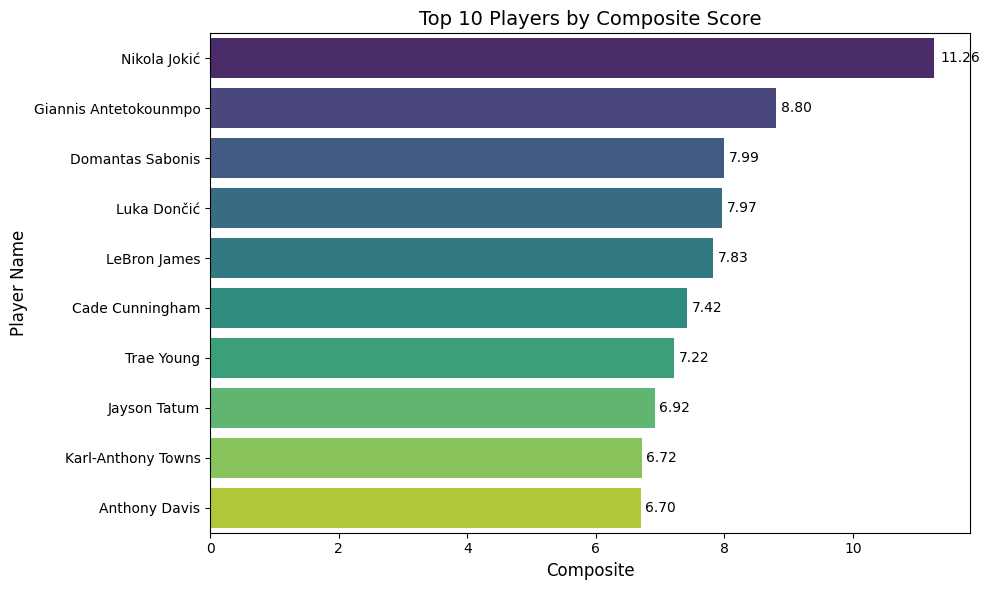

In [ ]:

import seaborn as sns

def graph_ranking_bar(df, value_col, title, top_n=10):
    """
    Creates a horizontal bar chart of the top ranked players based on a specified value column.
    """
    top_df = df.head(top_n)

    plt.figure(figsize=(10, 6))
    bar_plot = sns.barplot(
        x=value_col,
        y='PLAYER_NAME',
        data=top_df,
        palette='viridis'
    )

    for i, v in enumerate(top_df[value_col]):
        bar_plot.text(v + 0.01 * v, i, f"{v:.2f}", color='black', va='center')

    plt.title(title, fontsize=14)
    plt.xlabel(value_col, fontsize=12)
    plt.ylabel('Player Name', fontsize=12)
    plt.tight_layout()
    plt.show()

graph_ranking_bar(points_ranking, 'PTS', 'Top 10 Players by Average Points')

graph_ranking_bar(composite_rank, 'Composite', 'Top 10 Players by Composite Score')


# Team Performance

In [ ]:
def composite_team_ranking():
    """
    Calculates a composite performance score for each team based on key stats.
    The composite score is computed as:
        z(PTS) + z(REB) + z(AST) + z(STL) + z(BLK) - z(Turnovers)
    """
    df = teamSeasonData.copy()

    required_columns = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'Turnovers']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' is missing from teamSeasonData.")

    df['PTS_z'] = (df['PTS'] - df['PTS'].mean()) / df['PTS'].std()
    df['REB_z'] = (df['REB'] - df['REB'].mean()) / df['REB'].std()
    df['AST_z'] = (df['AST'] - df['AST'].mean()) / df['AST'].std()
    df['STL_z'] = (df['STL'] - df['STL'].mean()) / df['STL'].std()
    df['BLK_z'] = (df['BLK'] - df['BLK'].mean()) / df['BLK'].std()
    df['Turnovers_z'] = (df['Turnovers'] - df['Turnovers'].mean()) / df['Turnovers'].std()

    df['Composite'] = (df['PTS_z'] + df['REB_z'] + df['AST_z'] +
                       df['STL_z'] + df['BLK_z'] - df['Turnovers_z'])

    df = df.sort_values(by='Composite', ascending=False).reset_index(drop=True)
    df['Rank'] = df.index + 1

    return df

team_composite = composite_team_ranking()
print("Team Composite Rankings:")
print(team_composite[['Rank', 'Team', 'PTS', 'REB', 'AST', 'STL', 'BLK', 'Turnovers', 'Composite']].head(10))


Team Composite Rankings:
   Rank Team    PTS   REB   AST   STL  BLK  Turnovers  Composite
0     1  OKC  119.6  44.7  26.6  10.5  5.7       11.1   7.581500
1     2  MEM  122.7  47.6  28.8   9.0  5.9       15.4   5.872019
2     3  DEN  121.1  45.8  31.1   8.2  4.8       13.5   4.344458
3     4  ATL  117.3  44.7  29.2   9.9  5.4       14.8   4.044003
4     5  GSW  113.3  45.9  29.1   9.1  5.1       13.2   3.597075
5     6  CLE  122.5  45.2  28.4   8.2  4.3       12.5   3.006000
6     7  SAS  114.1  43.9  29.1   8.2  5.9       13.3   2.989061
7     8  BOS  116.4  44.8  25.7   7.3  5.6       11.4   2.329605
8     9  IND  116.6  41.0  29.2   8.6  5.1       12.5   1.781928
9    10  HOU  113.7  48.7  23.1   8.4  5.0       13.2   1.330264


<ipython-input-10-11fa558f0925>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




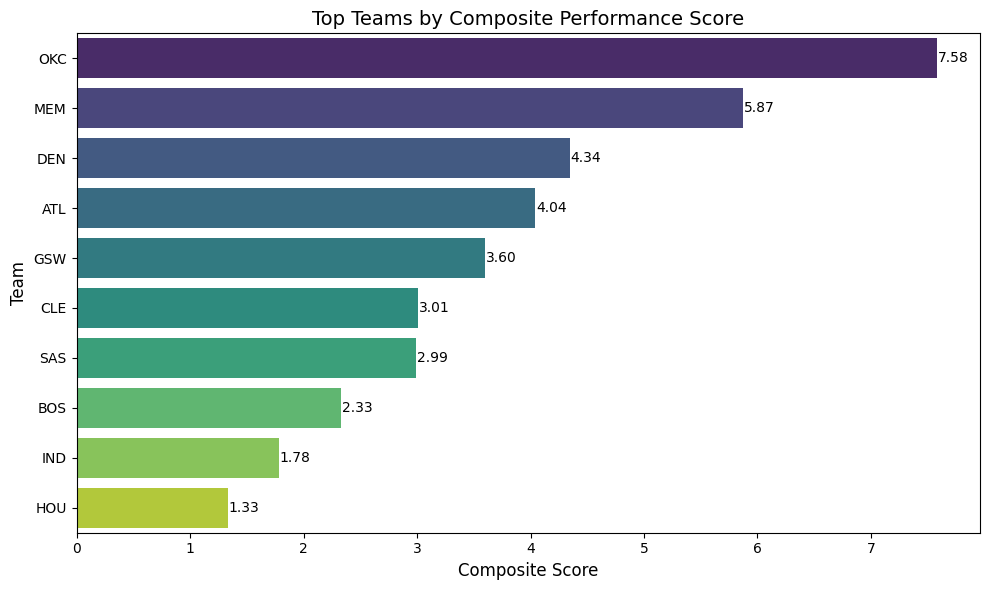

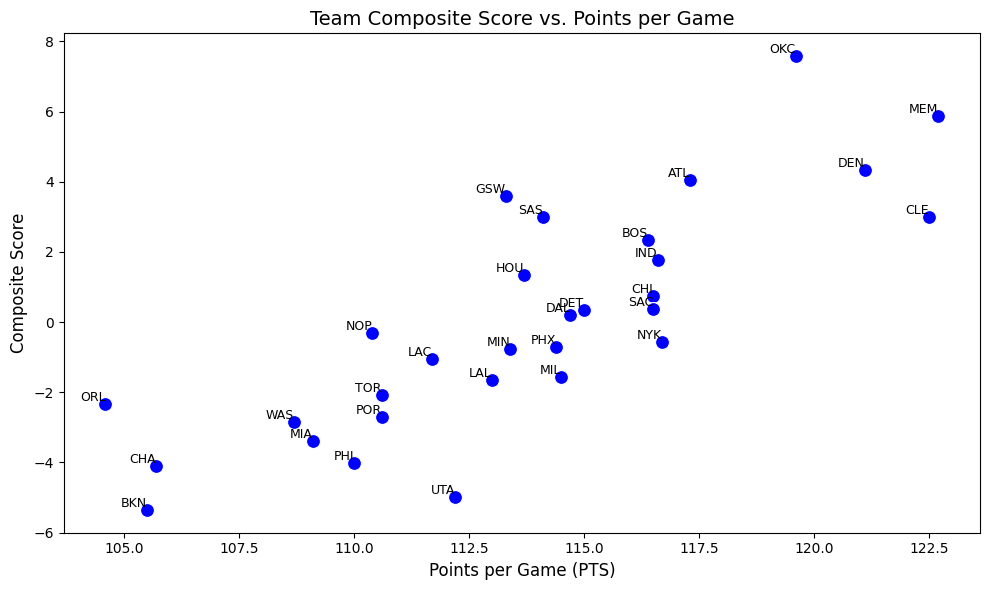

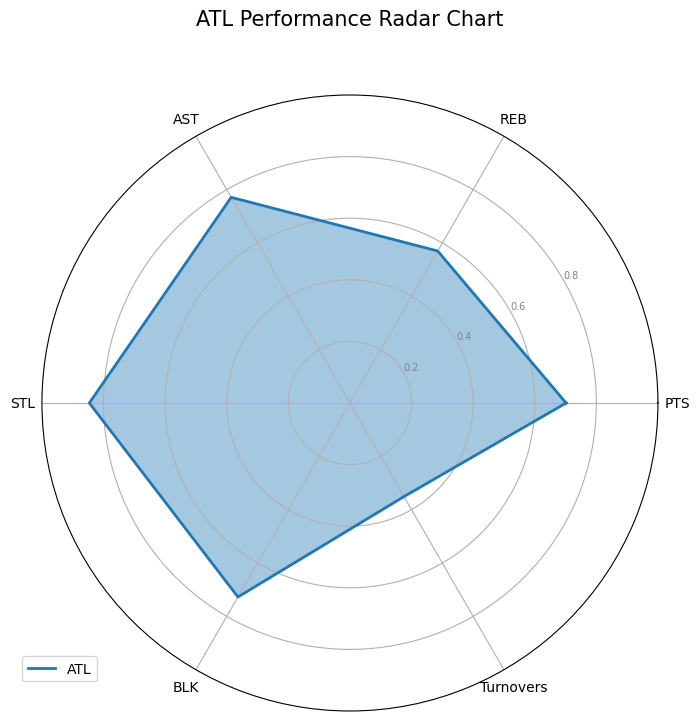

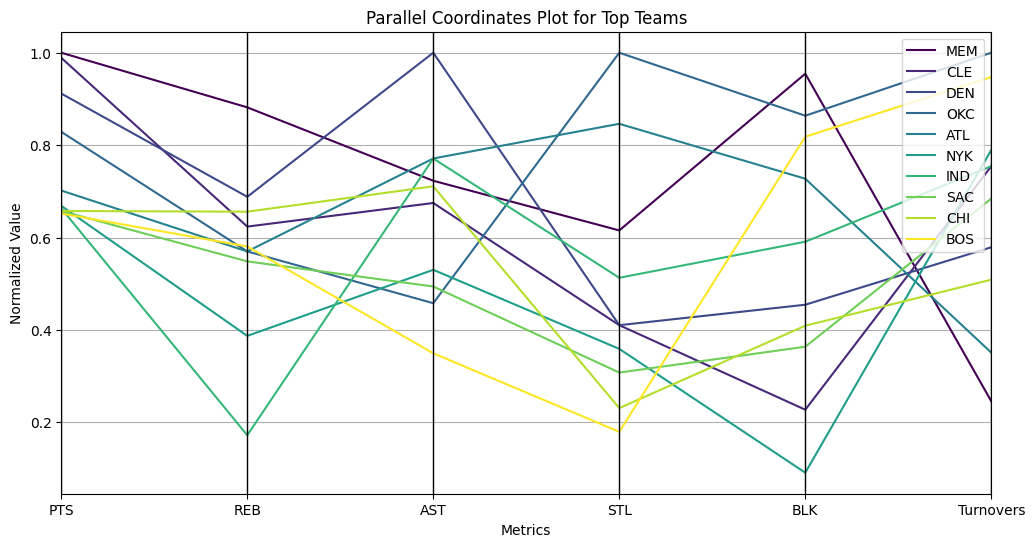

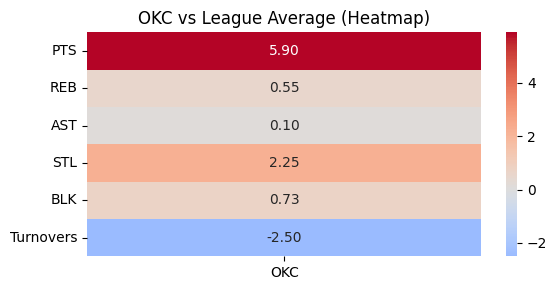

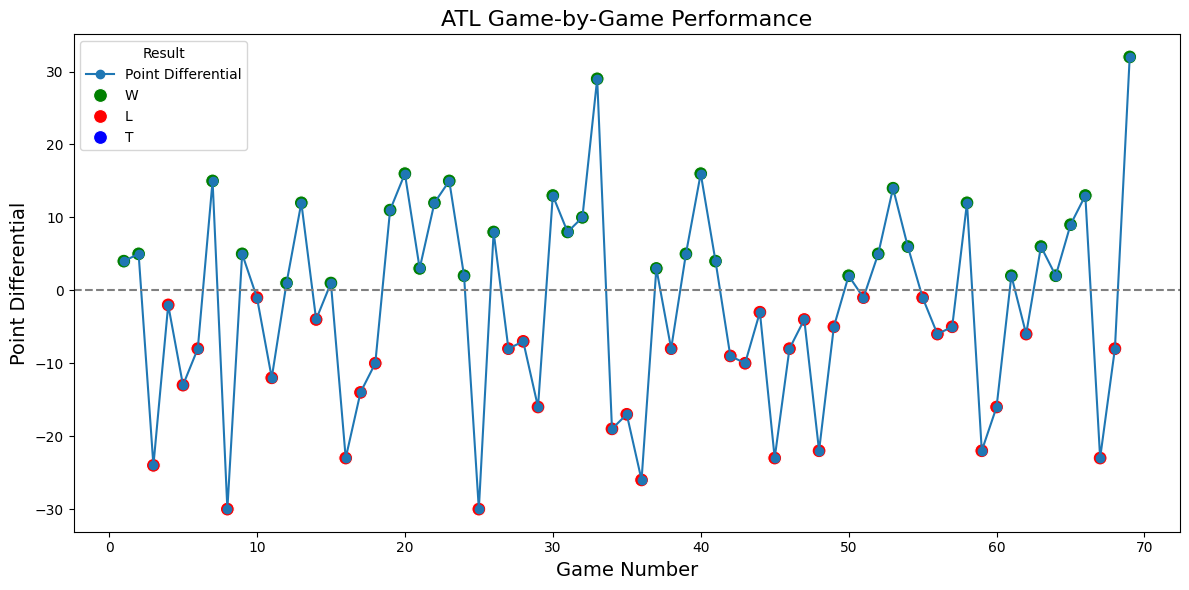

In [ ]:
def graph_team_composite_ranking(top_n=10):
    """
    Graphs a horizontal bar chart of the top teams based on the composite performance score.
    """
    df = composite_team_ranking()
    top_df = df.head(top_n)

    plt.figure(figsize=(10, 6))
    bar_plot = sns.barplot(
        x='Composite',
        y='Team',
        data=top_df,
        palette='viridis'
    )

    for i, v in enumerate(top_df['Composite']):
        bar_plot.text(v + 0.01, i, f"{v:.2f}", color='black', va='center')

    plt.title("Top Teams by Composite Performance Score", fontsize=14)
    plt.xlabel("Composite Score", fontsize=12)
    plt.ylabel("Team", fontsize=12)
    plt.tight_layout()
    plt.show()

graph_team_composite_ranking(top_n=10)


def graph_team_scatter():
    """
    Creates a scatter plot of each team's Points per Game vs. Composite Performance Score.
    Each point is annotated with the team name.
    """
    df = composite_team_ranking()

    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(
        data=df,
        x='PTS',
        y='Composite',
        s=100,
        color='blue'
    )

    for idx, row in df.iterrows():
        plt.text(row['PTS'], row['Composite'], row['Team'], fontsize=9, ha='right', va='bottom')

    plt.title("Team Composite Score vs. Points per Game", fontsize=14)
    plt.xlabel("Points per Game (PTS)", fontsize=12)
    plt.ylabel("Composite Score", fontsize=12)
    plt.tight_layout()
    plt.show()

graph_team_scatter()


def plot_radar_chart(df, team, metrics):
    """
    Plots a radar chart for a single team across the specified metrics.
    """
    team_data = df[df['Team'] == team][metrics].iloc[0]

    normalized = (team_data - df[metrics].min()) / (df[metrics].max() - df[metrics].min())
    values = normalized.values.tolist()
    values += values[:1]

    num_metrics = len(metrics)
    angles = [n / float(num_metrics) * 2 * np.pi for n in range(num_metrics)]
    angles += angles[:1]

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], metrics)

    ax.set_rlabel_position(30)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=7)
    plt.ylim(0,1)

    ax.plot(angles, values, linewidth=2, linestyle='solid', label=team)
    ax.fill(angles, values, alpha=0.4)

    plt.title(f"{team} Performance Radar Chart", size=15, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

metrics = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'Turnovers']
team_data = teamSeasonData.copy()
team_data['Turnovers'] = -team_data['Turnovers']
plot_radar_chart(team_data, team='ATL', metrics=metrics)


def plot_parallel_coordinates(df, metrics, class_column='Team'):
    """
    Plots a parallel coordinates chart for multiple teams.
    """
    df_norm = df.copy()
    for col in metrics:
        df_norm[col] = (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min())

    top_df = df_norm.sort_values(by=metrics[0], ascending=False).head(10)

    plt.figure(figsize=(12, 6))
    pd.plotting.parallel_coordinates(top_df[[class_column] + metrics], class_column, colormap='viridis')
    plt.title("Parallel Coordinates Plot for Top Teams")
    plt.xlabel("Metrics")
    plt.ylabel("Normalized Value")
    plt.show()

team_data = teamSeasonData.copy()
team_data['Turnovers'] = -team_data['Turnovers']
plot_parallel_coordinates(team_data, metrics=metrics, class_column='Team')


def plot_team_heatmap(df, team_name):
    """
    Plots a heatmap of the metrics for a specific team.
    """
    # Filter team data
    team_data = df[df['Team'] == team_name][metrics].iloc[0]

    # Calculate league averages
    league_avg = df[metrics].mean()

    # Calculate difference from league average
    diff = team_data - league_avg

    # Convert to DataFrame for heatmap
    diff_df = pd.DataFrame(diff, columns=[team_name])

    # Plot heatmap
    plt.figure(figsize=(6, len(metrics)*0.5))
    sns.heatmap(diff_df, annot=True, cmap='coolwarm', center=0, fmt=".2f")
    plt.title(f"{team_name} vs League Average (Heatmap)")
    plt.tight_layout()
    plt.show()

plot_team_heatmap(teamSeasonData, 'OKC')


def process_team_schedule(team_name):
    """
    Processes the teamSchedule DataFrame for a given team.
    """
    games = teamSchedule[(teamSchedule['hometeam'] == team_name) | (teamSchedule['awayteam'] == team_name)].copy()
    games['datetime'] = pd.to_datetime(games['datetime'])

    def parse_score(row):
        try:
            parts = row['score'].split('-')
            away_score = float(parts[0])
            home_score = float(parts[1])
        except Exception as e:
            away_score, home_score = None, None
        if row['hometeam'] == team_name:
            team_score = home_score
            opp_score = away_score
        elif row['awayteam'] == team_name:
            team_score = away_score
            opp_score = home_score
        else:
            team_score, opp_score = None, None
        return pd.Series({'team_score': team_score, 'opp_score': opp_score})

    scores = games.apply(parse_score, axis=1)
    games = pd.concat([games, scores], axis=1)

    games['PointDiff'] = games['team_score'] - games['opp_score']
    games['ComputedResult'] = games['PointDiff'].apply(lambda x: 'W' if x > 0 else ('L' if x < 0 else 'T'))
    games.sort_values(by='datetime', inplace=True)
    games['GameNumber'] = range(1, len(games) + 1)
    return games

def plot_team_game_performance(team_name):
    """
    Plots the game-by-game performance for a given team.
    """
    games = process_team_schedule(team_name)

    plt.figure(figsize=(12, 6))

    plt.plot(games['GameNumber'], games['PointDiff'], marker='o', linestyle='-', label='Point Differential')

    palette = {'W': 'green', 'L': 'red', 'T': 'blue'}
    sns.scatterplot(x='GameNumber', y='PointDiff', hue='ComputedResult', data=games, palette=palette, s=100, legend='brief')

    plt.axhline(0, color='grey', linestyle='--')
    plt.title(f"{team_name} Game-by-Game Performance", fontsize=16)
    plt.xlabel("Game Number", fontsize=14)
    plt.ylabel("Point Differential", fontsize=14)
    plt.legend(title="Result")
    plt.tight_layout()
    plt.show()

plot_team_game_performance('ATL')



# **User Input**

<ipython-input-4-ed1ca4e72cd6>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



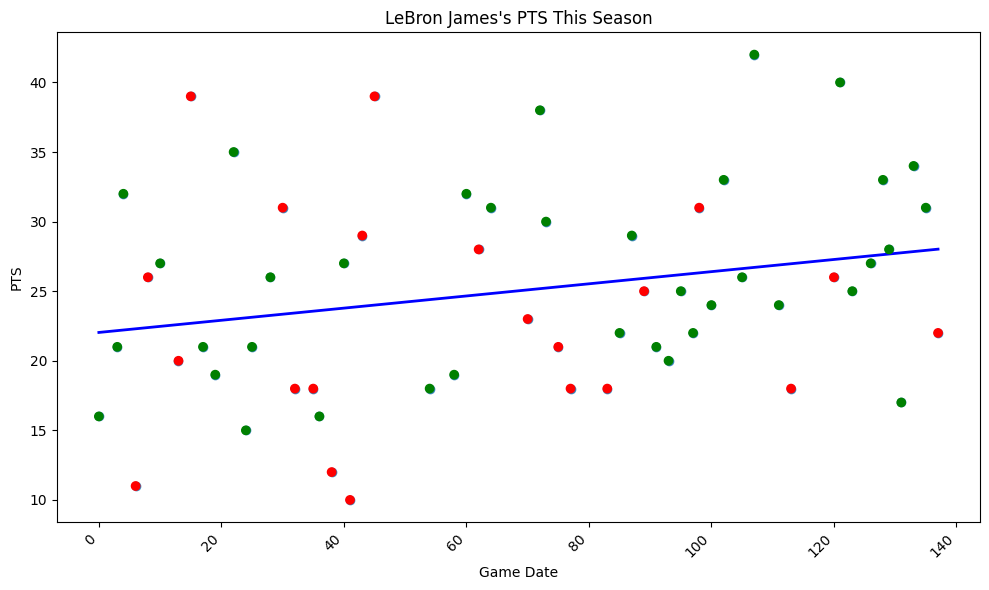

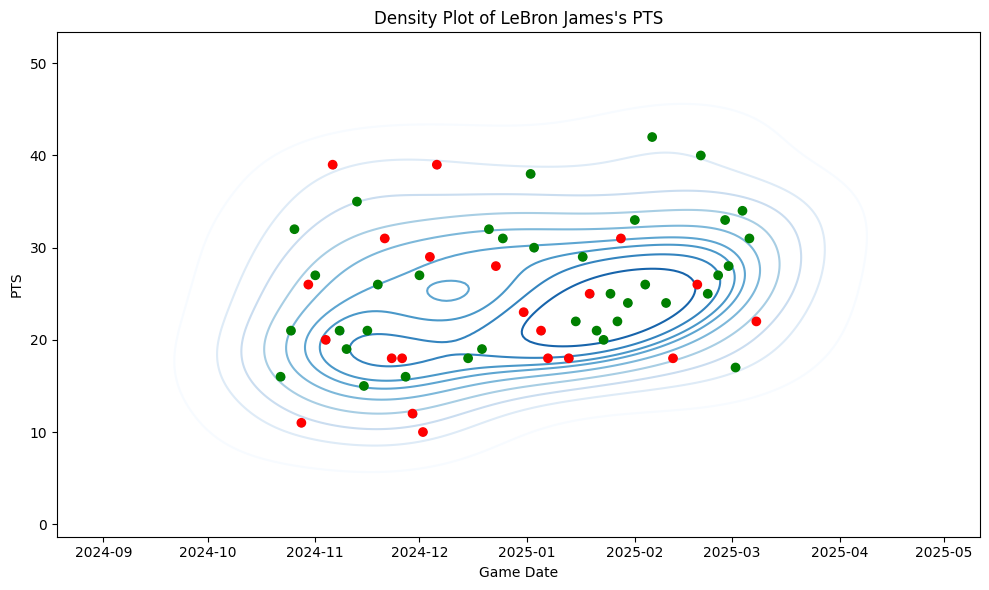

<ipython-input-4-ed1ca4e72cd6>:103: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-8-3d9e2977af60>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




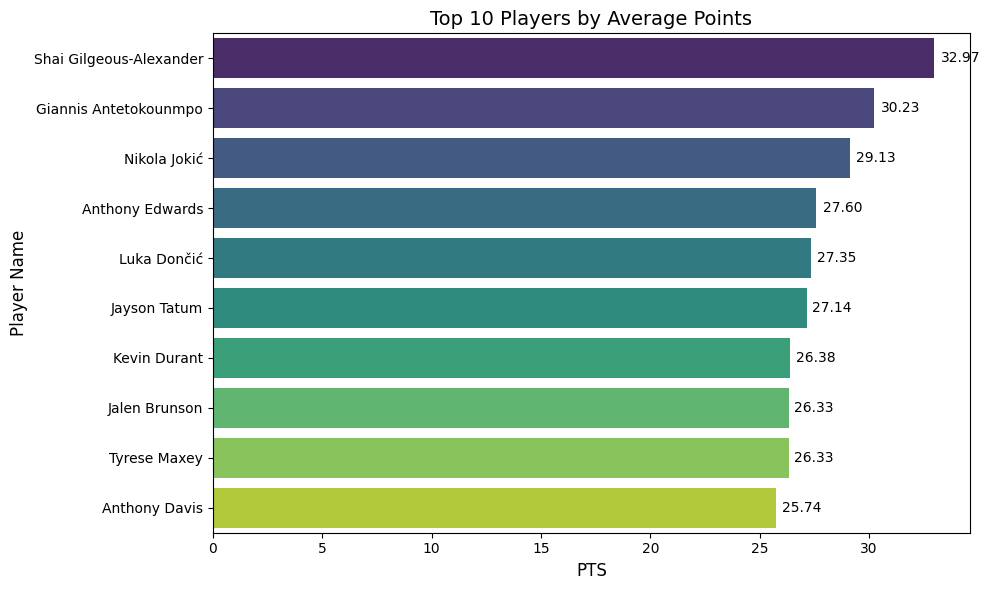

<ipython-input-8-3d9e2977af60>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




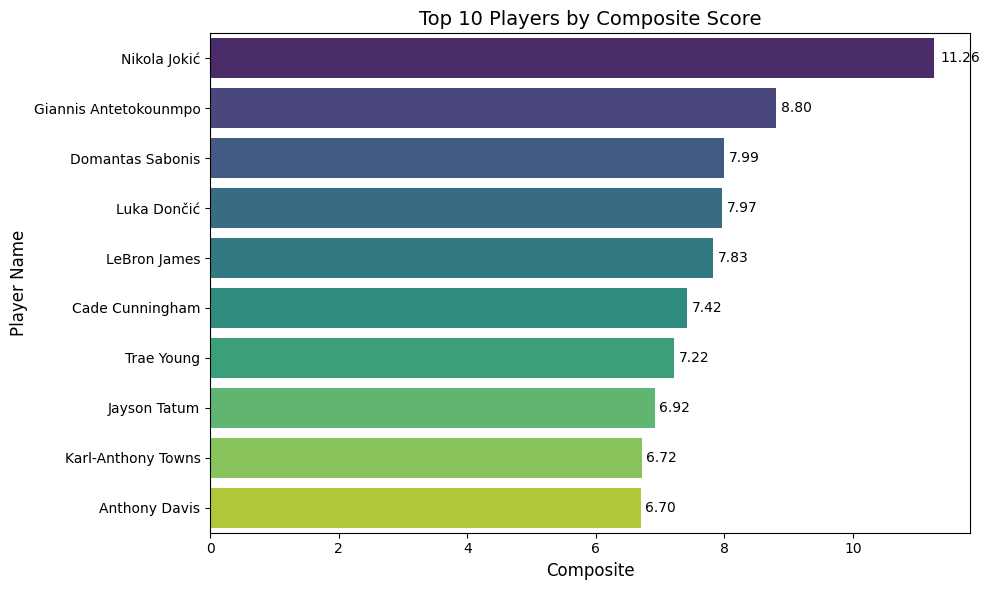

<ipython-input-10-11fa558f0925>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




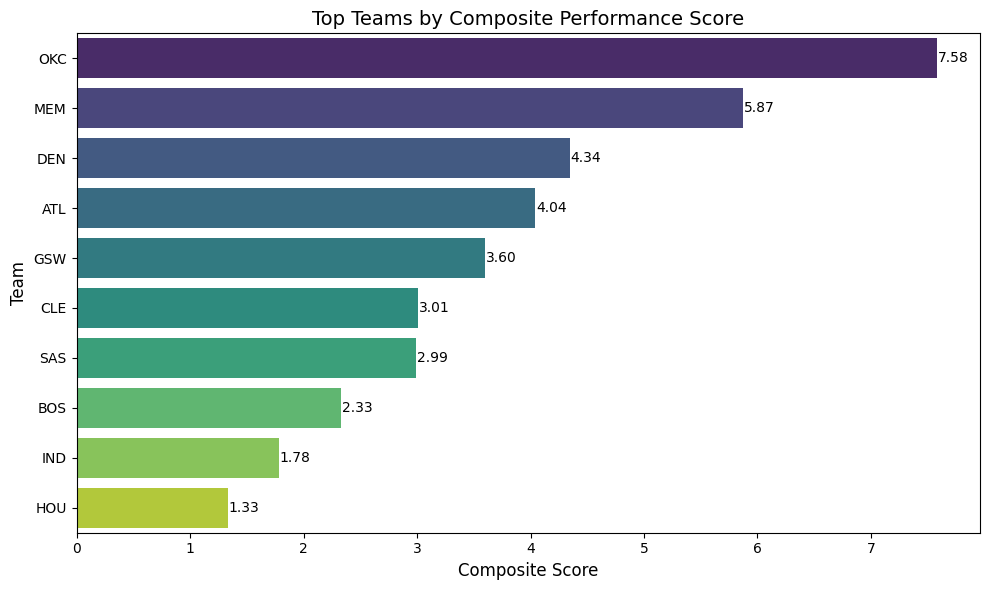

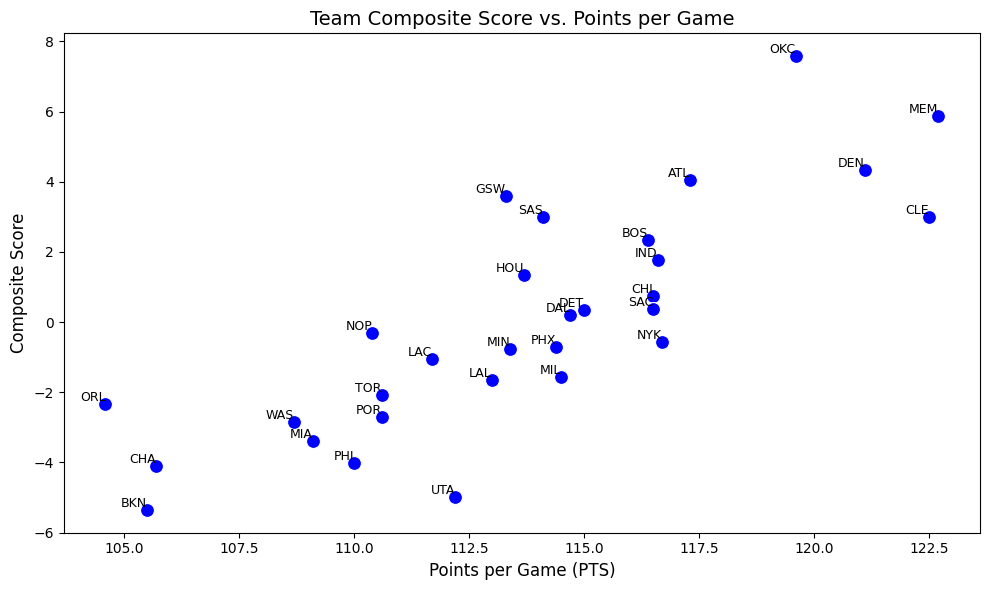

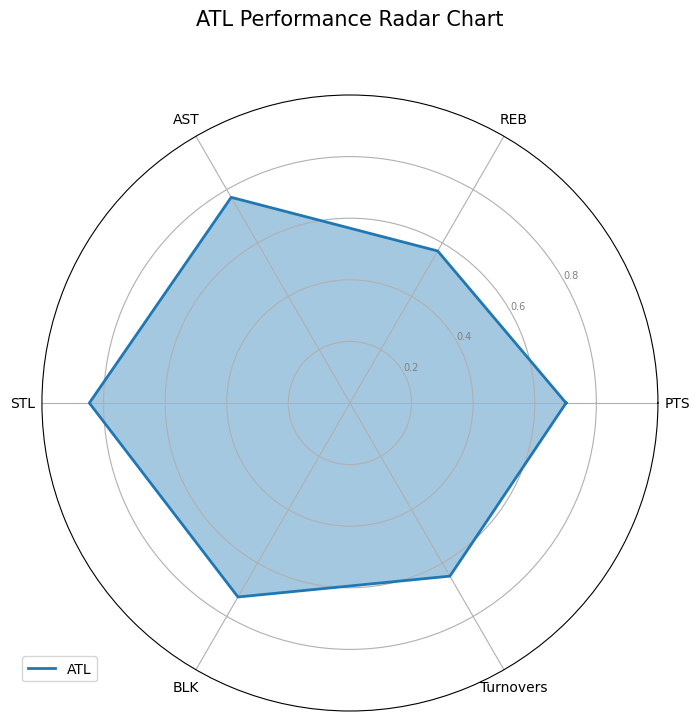

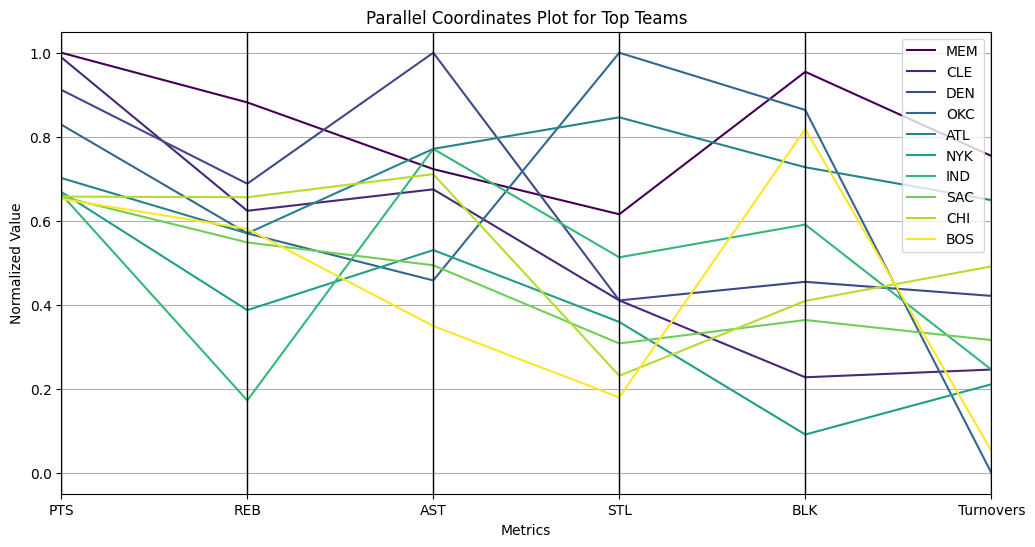

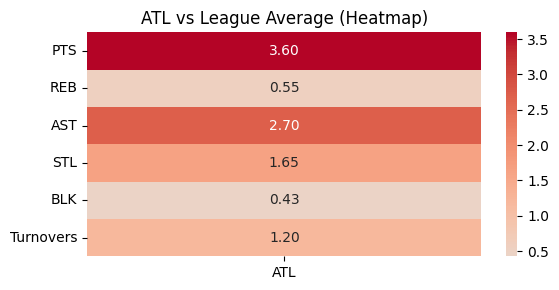

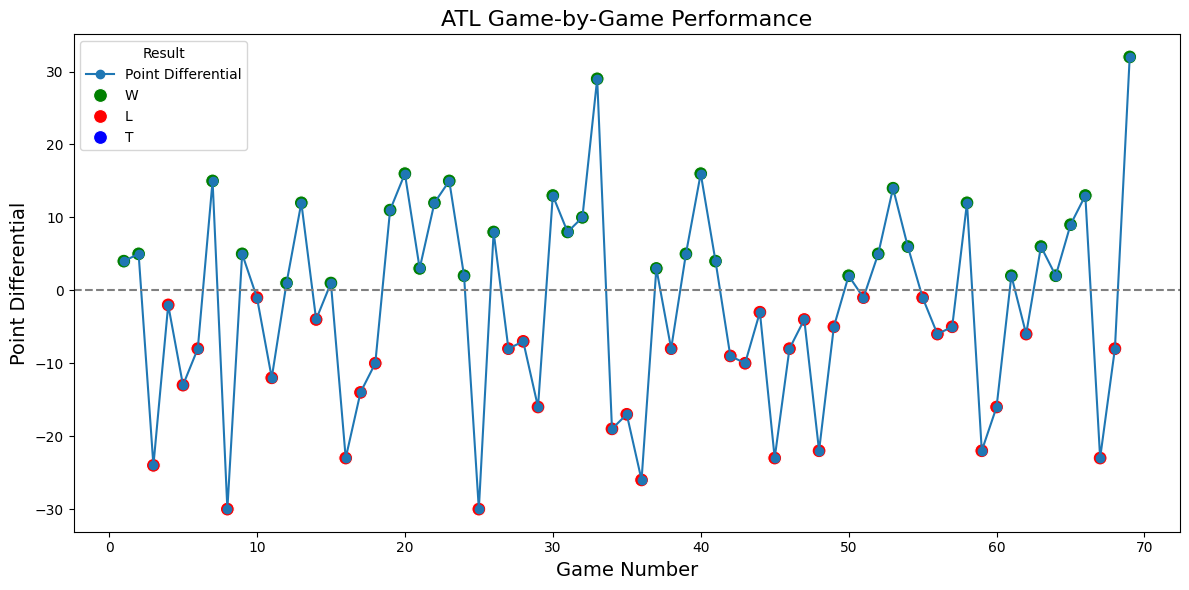

In [ ]:
# Add inputs
playerName = 'LeBron James'
stat = 'PTS'
stats=['PTS', 'REB', 'AST']
metrics = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'Turnovers']
team = 'ATL'
# Player Performance
graphPlayerScatterPlot(playerName, stat)
graphPlayerDensityPlot(playerName, stat)
graphTimeSeriesPlot(playerName, stat)
graphTimeSeriesPlotAllStats(playerName)

# Ranking Players
points_ranking = rank_players_by_stat(stat, False)
composite_rank = composite_ranking(stats)
graph_ranking_bar(points_ranking, stat, 'Top 10 Players by Average Points')
graph_ranking_bar(composite_rank, 'Composite', 'Top 10 Players by Composite Score')

# Team Performance
graph_team_composite_ranking(top_n=10)
graph_team_scatter()
plot_radar_chart(teamSeasonData, team=team, metrics=metrics)
plot_parallel_coordinates(teamSeasonData, metrics=metrics, class_column='Team')
plot_team_heatmap(teamSeasonData, team)
plot_team_game_performance(team)